In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import numpy as np
import cv2
import os

In [0]:
#hyperparameters
init_lr=1e-3
epochs=25
bs=8

In [0]:
imagePaths=list(paths.list_images("/content/drive/My Drive/covid19-dataset"))
data=[]
labels=[]

for imagePath in imagePaths:
  label=imagePath.split(os.path.sep)[-2]
  image=cv2.imread(imagePath)
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))

  data.append(image)
  labels.append(label)

data=np.array(data)/255.0
labels=np.array(labels)

In [0]:
#one-hot encoding of labels
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
print(labels)

(trainX,testX,trainY,testY)=train_test_split(data,labels,test_size=0.2,stratify=labels,random_state=42)

trainAug=ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [0]:
#load and replace head of VGG16
baseModel=VGG16(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(4,4))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(64,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

#combine
model=Model(inputs=baseModel.input,outputs=headModel)

#freeze layers in base model
for layer in baseModel.layers:
  layer.trainable=False





58892288/58889256 [==============================] - 1s 0us/step








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
opt=Adam(lr=init_lr,decay=init_lr/epochs)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

#train
H=model.fit_generator(
    trainAug.flow(trainX,trainY,batch_size=bs),
    steps_per_epoch=len(trainX)//bs,
    validation_data=(testX,testY),
    validation_steps=len(testX)/bs,
    epochs=epochs
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
5/5 [==============================] - 26s 5s/step - loss: 0.7332 - acc: 0.5000 - val_loss: 0.6147 - val_acc: 0.7000
Epoch 2/25
5/5 [==============================] - 25s 5s/step - loss: 0.6104 - acc: 0.6250 - val_loss: 0.5965 - val_acc: 0.6000
Epoch 3/25
5/5 [==============================] - 25s 5s/step - loss: 0.6462 - acc: 0.6500 - val_loss: 0.5749 - val_acc: 0.9000
Epoch 4/25
5/5 [==============================] - 25s 5s/step - loss: 0.6691 - acc: 0.6250 - val_loss: 0.5622 - val_acc: 0.9000
Epoch 5/25
5/5 [==============================] - 25s 5s/step - loss: 0.6270 - acc: 0.6500 - val_loss: 0.5489 - val_acc: 1.0000
Epoch 6/25
5/5 [==============================] - 25s 5s/step - loss: 0.5635 - acc: 0.6750 - val_loss: 0.5329 - val_acc: 1.0000
Epoch 7/25
5/5 [==============================] - 25s 5s/step - loss: 0.5315 - acc: 0.7250 - val_loss: 0.5172 - val_acc: 1.0000
Epoch 

In [0]:
predIdxs = model.predict(testX, batch_size=bs)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [0]:
#confusion matrix
cm=confusion_matrix(testY.argmax(axis=1),predIdxs)
total=sum(sum(cm))
acc=(cm[0,0]+cm[1,1])/total
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
specificity=cm[1,1]/(cm[1,0]+cm[1,1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [1 4]]
acc: 0.9000
sensitivity: 1.0000
specificity: 0.8000


KeyError: ignored

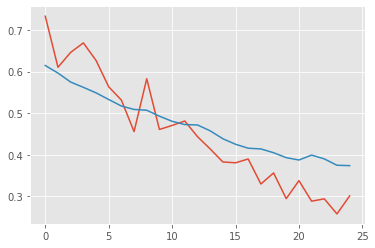

In [0]:
# plot training loss and accuracy
import matplotlib.pyplot as plt

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [0]:
model.save("/content/drive/My Drive/covid19-dataset/covid191.h5")

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

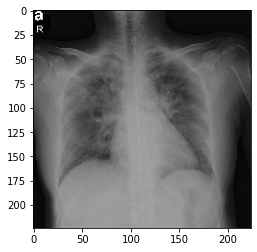

In [20]:
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import load_model
import matplotlib.pyplot as plt

model=load_model("/content/drive/My Drive/covid19-dataset/covid191.h5")
_img=load_img("/content/drive/My Drive/covid19-dataset/testing-set/test1.jpg",target_size=(224,224))
img=img_to_array(_img)
img=np.expand_dims(img,axis=0)
img=preprocess_input(img)
#plt.subplot(1,2,1)
plt.imshow(_img)
#plt.subplot(1,2,2)
#plt.imshow(img)
plt.show()

features=model.predict(img)

#for GradCAM
class_idxs_sorted = np.argsort(features.flatten())[::-1]

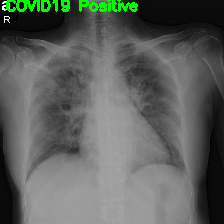

In [10]:
from google.colab.patches import cv2_imshow #colab does not support cv2.imshow
image=cv2.imread("/content/drive/My Drive/covid19-dataset/testing-set/test1.jpg")
image=cv2.resize(image,(224,224))
if features[0][0]>features[0][1]:
  cv2.putText(image,'COVID19 Positive',(5,10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,0),2)
  cv2_imshow(image)
else:
  cv2.putText(image,'COVID19 Negative',(5,10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,0),2)
  cv2_imshow(image)

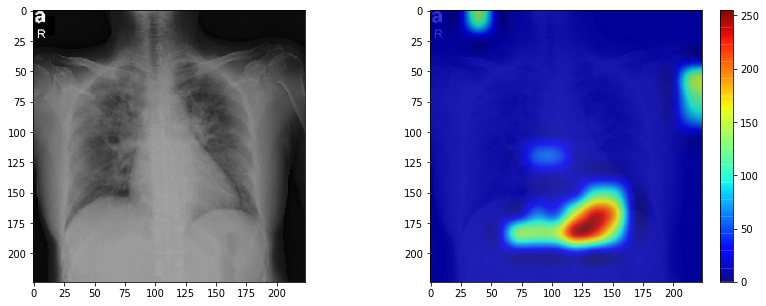

In [22]:
import vis
import keras
from keras.models import load_model
from vis.utils import utils
from vis.visualization import visualize_cam
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions

#img=load_img("/content/drive/My Drive/covid19-dataset/covid/test1.jpg",target_size=(224,224))
model=load_model("/content/drive/My Drive/covid19-dataset/covid191.h5")

layer_idx=utils.find_layer_idx(model,"block5_conv3")
model.layers[layer_idx].activation=keras.activations.linear
model=utils.apply_modifications(model)
penultimate_layer_idx=utils.find_layer_idx(model,"block5_conv3")
class_idx=class_idxs_sorted[0]
seed_input=img
grad_top1=visualize_cam(model,layer_idx,class_idx,seed_input,
                        penultimate_layer_idx=penultimate_layer_idx,
                        backprop_modifier=None,
                        grad_modifier=None)

def plot_map(grads):
  fig,axes=plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(_img)
  axes[1].imshow(_img)
  i=axes[1].imshow(grads,cmap="jet",alpha=0.8)
  fig.colorbar(i)
plot_map(grad_top1)

**NOTE:**
Line 5: <code> from vis.visualization import visualize_cam </code> requires <code> imresize </code> which has since been removed from the latest version of <code> scipy </code><br> Would need to degrade scipy to v1.1.0 to get <code> imresize </code>

In [18]:
print(type(img))

<class 'PIL.Image.Image'>
